In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

---
#The Iris Dataset
---

In [2]:
#The Iris Dataset is a builtin dataset, you need from sklearn import datasets - see above

iris = datasets.load_iris()
print iris.target_names
print iris.DESCR

['setosa' 'versicolor' 'virginica']
Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:
    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================
    

In [3]:
#here is how you access the data and the class labels
print iris.data.shape
print iris.data[:5]
print iris.target.shape
print iris.target[:5]

(150, 4)
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
(150,)
[0 0 0 0 0]


---
##Construct a Pandas dataframe
---

In [4]:
df = {'class':iris.target, 'sepal_length':iris.data[:,0], 'sepal_width':iris.data[:,1], \
      'petal_length':iris.data[:,2], 'petal_width':iris.data[:,3]}

In [5]:
df = pd.DataFrame(df)

In [6]:
#We will need a list of features only
features = df.columns[1:]
print features

Index([u'petal_length', u'petal_width', u'sepal_length', u'sepal_width'], dtype='object')


In [7]:
df.head()

,class,petal_length,petal_width,sepal_length,sepal_width
0,0,1.4,0.2,5.1,3.5
1,0,1.4,0.2,4.9,3.0
2,0,1.3,0.2,4.7,3.2
3,0,1.5,0.2,4.6,3.1
4,0,1.4,0.2,5.0,3.6


---
## Scale the data, note I also scaled y
## Put the scaled data into a new dataframe
---

In [8]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(df[features])
df_scaled = pd.DataFrame(scaler.transform(df[features]), columns=features)

In [9]:
df_scaled['class'] = df['class'].values

In [10]:
df_scaled.head()

,petal_length,petal_width,sepal_length,sepal_width,class
0,-1.341272,-1.312977,-0.900681,1.032057,0
1,-1.341272,-1.312977,-1.143017,-0.124958,0
2,-1.398138,-1.312977,-1.385353,0.337848,0
3,-1.284407,-1.312977,-1.506521,0.106445,0
4,-1.341272,-1.312977,-1.021849,1.263460,0


---
##How well do these features correlate with the class?
---

In [11]:
df_scaled.corrwith(df_scaled['class'])

petal_length    0.949043
petal_width     0.956464
sepal_length    0.782561
sepal_width    -0.419446
class           1.000000
dtype: float64

---
##Define a custom confusion matrix function 
---

In [12]:
def confusion_matrix(predictions, y, names):
    '''This function uses the pd.crosstab function to create a confusion matrix:
    predictions are the predictions from the predictive mode
    y are the known class labels
    names are the names of the features used in the model'''
    
    cf = pd.crosstab(y, predictions)
    cf.columns = names
    cf.index = names
    cf.columns.name = 'Prediction'
    cf.index.name = 'Actual'
    return cf

---
##Explained Variance
---

Explained variance for the 4 principal components:
[ 2.91081808  0.92122093  0.14735328  0.02060771]

Percentage of the total variance attributable to each Principal Component:
[ 72.77045209  23.03052327   3.68383196   0.51519268]

Cumulative percentage for the variance, adding each Principal Component in turn:
[  72.77045209   95.80097536   99.48480732  100.        ]


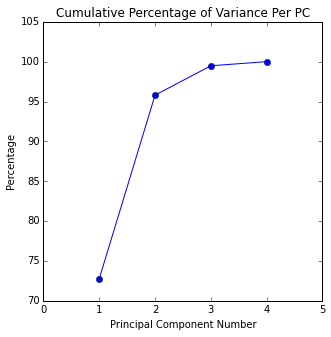

In [13]:
#Let's look at the explained variance for each of the principal components
myPCA = PCA(n_components = 4).fit(df_scaled[features])
print "Explained variance for the 4 principal components:\n", myPCA.explained_variance_

#Now calculate the contribution percentage to the whole variance
perc_ev = (myPCA.explained_variance_/myPCA.explained_variance_.sum())*100.0
cs_perc_ev = perc_ev.cumsum()
print "\nPercentage of the total variance attributable to each Principal Component:\n", perc_ev
print "\nCumulative percentage for the variance, adding each Principal Component in turn:\n", cs_perc_ev

fig = plt.figure(figsize = (5,5))
ax = plt.subplot(111)
ax.plot([1, 2, 3, 4], cs_perc_ev, color = 'blue', marker = 'o', label="Percentage of Variance")
ax.set_xlim(0,5)
ax.set_title("Cumulative Percentage of Variance Per PC")
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Percentage")

---
#Let's fit some models using 1 PC, 2 PCs, 3 PCs
##We are using the entire dataset, so over-fitting to the training set is a given
---

In [14]:
#fit a principal components analysis model with a single component
myPCA = PCA(n_components = 1).fit(df_scaled[features])

#Now transform the data - note that PCA has a fit_transform method to do both in one shot
X_transform = myPCA.transform(df_scaled[features])
print "The shape of the transformed data is ", X_transform.shape

#Fit a regularized logistic regression model
clf = LogisticRegression(C=100) 
clf.fit(X_transform, df_scaled['class'])

#print out the score and the confusion matrix
print "The score is {:5.2}".format(clf.score(X_transform, df_scaled['class']))
cm = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cm

The shape of the transformed data is  (150, 1)
The score is  0.91


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,40,10
virginica,0,4,46


---
###Repeat and use 2 principal components
---

In [15]:
myPCA = PCA(n_components = 2).fit(df_scaled[features])
X_transform = myPCA.transform(df_scaled[features])
clf = LogisticRegression(C=100) 
clf.fit(X_transform, df_scaled['class'])

#print out the score and the confusion matrix
print "The score is {:5.2}".format(clf.score(X_transform, df_scaled['class']))
cm = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cm

The score is  0.93


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,43,7
virginica,0,4,46


---
###Repeat and use 3 principal components
---

In [16]:
myPCA = PCA(n_components = 3).fit(df_scaled[features])
X_transform = myPCA.transform(df_scaled[features])
clf = LogisticRegression() 
clf.fit(X_transform, df_scaled['class'])

#print out the score and the confusion matrix
print "The score is {:5.2}".format(clf.score(X_transform, df_scaled['class']))
cm = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cm

The score is  0.91


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,40,10
virginica,0,4,46


---
##Adding Non-Linear Features
---

---
###Order matters!!
---

---
## A: PCA then Poylnomial
---

In [17]:
#Using PCA to reduce the dimensionality of your primary input features BEFORE creating non-linear features

#reduce the dataset to 2-D
myPCA = PCA(n_components = 2).fit(df_scaled[features])
#transform the dataset
X_transform = myPCA.transform(df_scaled[features])

print "The PCA dimension is {:d}".format(X_transform.shape[1])

clf = make_pipeline(PolynomialFeatures(3), LogisticRegression(C=1000))
print "The degree of polynomial used is {:d}".format(3)
print "The input dimension is {:d}".format(PolynomialFeatures(3).fit_transform(X_transform).shape[1])

clf.fit(X_transform, df_scaled['class'])
print "The score is {:5.2}".format(clf.score(X_transform, df_scaled['class']))

#print out the score and the confusion matrix
cm = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cm

The PCA dimension is 2
The degree of polynomial used is 3
The input dimension is 10
The score is  0.92


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,43,7
virginica,0,5,45


---
## B:  Poylnomial then PCA
---

In [18]:
#Here we use PCA to reduce the number of non-linear features

#Call polynomial features separately and get the transformed data
pf = PolynomialFeatures(3).fit_transform(df_scaled[features])
print "The degree of polynomial used is {:d}".format(3)


#Now use PCA on the polynomial features - taking only the first 4
myPCA = PCA(n_components = 4).fit(pf)

#Having got the fit transform the data for direct use with Logistic Regression
X_transform =  myPCA.transform(pf)
print "The Input Dimension is {:d}".format(X_transform.shape[1])


#Build and fit the logistic regression model
clf = LogisticRegression(C=1000)
clf.fit(X_transform, df_scaled['class'])
print "The score is {:5.5f}".format(clf.score(X_transform, df_scaled['class']))

cm = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cm

The degree of polynomial used is 3
The Input Dimension is 4
The score is 0.97333


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,48,2
virginica,0,2,48


---
#Correlation of the transformed variables
---

In [19]:
ppf = pd.DataFrame(X_transform)
ppf.corr()

,0,1,2,3
0,1.000000e+00,7.213599e-18,-4.158909e-17,3.175210e-16
1,7.213599e-18,1.000000e+00,-1.458624e-15,1.209712e-16
2,-4.158909e-17,-1.458624e-15,1.000000e+00,-5.605935e-17
3,3.175210e-16,1.209712e-16,-5.605935e-17,1.000000e+00


---
#A side-by-side comparison
---

In [20]:
#Let's use PCA to reduce the number of non-linear features we use

#Call polynomial features separately and get the transformed data
pf = PolynomialFeatures(3).fit_transform(df_scaled[features])

#No use PCA on the polynomial features - taking only the first 10 or 11
myPCA = PCA(n_components = 20).fit(pf)

#Having got the fit transform the data for direct use with Logistic Regression
X_transform =  myPCA.transform(pf)

#Build and fit the logistic regression model
clf = LogisticRegression(C=1000)
clf.fit(X_transform, df_scaled['class'])


print "Input Dimension is {:d}".format(X_transform.shape[1])
print "The score is {:5.5f}".format(clf.score(X_transform, df_scaled['class']))

cf = confusion_matrix(clf.predict(X_transform), df_scaled['class'], iris.target_names)
cf

Input Dimension is 20
The score is 1.00000


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


---
##Without any dimensionality reduction at all!
---

In [21]:
#for comparison we make the pipeline and fit to build the model - no PCA
clf = make_pipeline(PolynomialFeatures(3), LogisticRegression(C=1000))
clf.fit(df_scaled[features], df_scaled['class'])

print "Input Dimension is {:d}".format(PolynomialFeatures(3).fit_transform(df_scaled[features]).shape[1])
print "The score is {:5.5f}".format(clf.score(df_scaled[features], df_scaled['class']))
cm = pd.crosstab(df_scaled['class'], clf.predict(df_scaled[features]))
cm.columns = iris.target_names
cm.index = iris.target_names
cm.columns.name = 'Predicted'
cm.index.name = 'Actual'
cm

Input Dimension is 35
The score is 1.00000


Predicted,setosa,versicolor,virginica
Actual,,,
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


---
#Same results but with a input dimension of 15 fewer features using PCA
---